## Imports

In [0]:
import itertools
from functools import reduce
import operator
import tensorflow as tf
import time
import random
import layers
import math
import argparse
import parseutils as pu
import utils
import pandas as pd
import numpy as np
from layers import maxclip, fc
# from utils import msgtime, str_memusage, print_prog_bar, fcn_stats
import csv
import matplotlib.pyplot as plt

In [0]:
# Set up random seeds
seed = 1234
np.random.seed(seed)
tf.set_random_seed(seed)

##  Dataset Preparation

In [0]:
dataset = pd.read_csv('Iris_Dataset.csv')
dataset = pd.get_dummies(dataset, columns=['Species']) # One Hot Encoding
values = list(dataset.columns.values)

In [0]:
y = dataset[values[-3:]]
y = np.array(y, dtype='float32')
X = dataset[values[1:-3]]
X = np.array(X, dtype='float32')

In [0]:
# Shuffle Data
indices = np.random.choice(len(X), len(X), replace=False)
X_values = X[indices]
y_values = y[indices]

In [0]:
# Creating a Train and a Test Dataset
test_size = 50
X_test = X_values[-test_size:]
X_train = X_values[:-test_size]
y_test = y_values[-test_size:]
y_train = y_values[:-test_size]

## Set up models

In [0]:
base_config = dict(
    N_IN = 4,                            # Number of Feature Inputs
    N_BATCHSIZE = 32,                    # Batch size
    N_PARTICLES = 32,                    # Number of Particles
    G_BEST_FACTOR = 0.8,                 # Global Best for PSO
    L_BEST_FACTOR = 0.7,                 # Local Best for PSO
    P_BEST_FACTOR = 0.6,                 # Personal Best for PSO
    VELOCITY_DECAY = 1,                  # Decay in velocity after each position update
    MAX_VEL = 0.005,                     # Maximum velocity for a particle if restricted
    MAX_VEL_DECAY = 1,                   # Multiplier for Max Velocity with each update
    N_ITERATIONS = int(1e2),             # Number of iterations
    HIDDEN_LAYERS = [3, 2],              # Hidden layer dim
    LEARNING_RATE = 0.1,                  # Learning Rate

    # Other Params for image similarity
    c1=tf.constant(2.05,dtype=None,shape=None,name='c1'),
    c2=tf.constant(2.05,dtype=None,shape=None,name='c2'),
    chi = abs(2.0 / (2.0 - 4.1 - math.sqrt(4.1 * 4.1 - 4.0 * 4.1)))
    )

LAYERS = [base_config["N_IN"]] + base_config["HIDDEN_LAYERS"] + [3]
t_VELOCITY_DECAY = tf.constant(value=base_config["VELOCITY_DECAY"],
                               dtype=tf.float32,
                               name='vel_decay')
t_MVEL = tf.Variable(base_config["MAX_VEL"],
                     dtype=tf.float32,
                     name='vel_restrict')
net_in = tf.placeholder(dtype=tf.float32,
                        shape=[None, 4],
                        name='net_in')
label = tf.placeholder(dtype=tf.float32,
                           shape=[None, 3],
                           name='net_label')



In [0]:
# MULTI-PARTICLE NEURAL NETS
losses = []
nets = []
pweights = []
pbiases = []
vweights = []
vbiases = []
pfitlist = []
pweightslist=[]
vweightslist=[]
pbiaseslist=[]
vbiaseslist=[]
weightslist=[]
biaseslist=[]
netlist=[]
len_weights=tf.placeholder(dtype=tf.int32,shape=[])
random_values = []
accuracy_updates=[]

# Positional Updates
bias_updates = []
weight_updates = []

# Velocity Updates
vweight_updates = []
vbias_updates = []

# Fitness Updates
fit_updates = []

# Control Updates - Controling PSO inside tf.Graph
control_updates = []

# Hybrid Updates - Using of PSO + Traditional Approaches
hybrid_updates = []

# Global Best
gweights = []
gbiases = []
gfit = tf.Variable(math.inf, name='gbestfit')

# Local Best
lweights= []
lbiases =[]
lfitlist=[]
lweightslist=[]
lbiaseslist=[]
lbestindex = tf.Variable(math.inf, name='lbestindex')

In [9]:
for pno in range(base_config["N_PARTICLES"]):
    weights = []
    biases = []
    pweights = []
    pbiases = []
    pbestrand = tf.Variable(tf.random_uniform(
        shape=[], maxval=base_config["P_BEST_FACTOR"]),
        name='pno' + str(pno + 1) + 'pbestrand')
    gbestrand = tf.Variable(tf.random_uniform(
    shape=[], maxval=base_config["G_BEST_FACTOR"]),
    name='pno' + str(pno + 1) + 'gbestrand')

    # Append the random values so that the initializer can be called again
    random_values.append(pbestrand)
    random_values.append(gbestrand)
    pfit = tf.Variable(math.inf, name='pno' + str(pno + 1) + 'fit')
    net = net_in
    # Define the parameters

    for idx, num_neuron in enumerate(LAYERS[1:]):
        layer_scope = 'pno' + str(pno + 1) + 'fc' + str(idx + 1)
        net, pso_tupple = fc(input_tensor=net,
                             n_output_units=num_neuron,
                             activation_fn='sigmoid',
                             scope=layer_scope,
                             uniform=True)
        w, b, pw, pb, vw, vb = pso_tupple
        vweights.append(vw)
        vbiases.append(vb)
        vweightslist.append(pw)
        vbiaseslist.append(pb)
        weights.append(w)
        weightslist.append(w)
        biaseslist.append(b)
        biases.append(b)
        pweights.append(pw)
        pbiases.append(pb)
        pweightslist.append(pw)
        pbiaseslist.append(pb)
        netlist.append(net)
        lw = tf.Variable(tf.random_uniform(
                shape=[LAYERS[idx],LAYERS[idx+1]],
                dtype=tf.float32),
                name='lw')
        lb = tf.Variable(tf.random_uniform(
                shape=[LAYERS[idx+1]],
                dtype=tf.float32),
                name='lb')
        lweightslist.append(lw)
        lbiaseslist.append(lb)

        nextvw = tf.multiply(vw, t_VELOCITY_DECAY)
        nextvb = tf.multiply(vb, t_VELOCITY_DECAY)

        # Differences between Particle Best & Current
        pdiffw = tf.multiply(tf.subtract(pw, w), pbestrand)
        pdiffb = tf.multiply(tf.subtract(pb, b), pbestrand)
        # Define & Reuse the GBest
        gw = None
        gb = None
        with tf.variable_scope("gbest", reuse=tf.AUTO_REUSE):
            gw = tf.get_variable(name='fc' + str(idx + 1) + 'w',
                             shape=[LAYERS[idx], LAYERS[idx + 1]],
                             initializer=tf.zeros_initializer)

            gb = tf.get_variable(name='fc' + str(idx + 1) + 'b',
                             shape=[LAYERS[idx + 1]],
                             initializer=tf.zeros_initializer)

        # If first Particle add to Global Else it is already present

        if pno == 0:
            gweights.append(gw)
            gbiases.append(gb)

        # Differences between Global Best & Current
        gdiffw = tf.multiply(tf.subtract(gw, w), gbestrand)
        gdiffb = tf.multiply(tf.subtract(gb, b), gbestrand)
        vweight_update = None
        vweight_update = tf.assign(vw,
                                 tf.add_n([nextvw, pdiffw, gdiffw]),
                                 validate_shape=True)
       

        vweight_updates.append(vweight_update)
        vbias_update = None
        vbias_update = tf.assign(vb,
                                 tf.add_n([nextvb, pdiffb, gdiffb]),
                                 validate_shape=True)
        vbias_updates.append(vbias_update)
        weight_update = tf.assign(w, w + vw, validate_shape=True)
        weight_updates.append(weight_update)
        bias_update = tf.assign(b, b + vb, validate_shape=True)
        bias_updates.append(bias_update)


    loss = tf.reduce_mean(-tf.reduce_sum(label* tf.log(net), axis=0))
    correct_prediction = tf.equal(tf.argmax(net, 1), tf.argmax(label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_updates.append(accuracy)
    particlebest = tf.cond(loss < pfit, lambda: loss, lambda: pfit)
    fit_update = tf.assign(pfit, particlebest, validate_shape=True)
    fit_updates.append(fit_update)
    globalbest = tf.cond(loss < gfit, lambda: loss, lambda: gfit)
    fit_update = tf.assign(gfit, globalbest, validate_shape=True)
    fit_updates.append(fit_update)
    pfitlist.append(pfit)
    control_update = tf.assign(t_MVEL, tf.multiply(t_MVEL,base_config["MAX_VEL_DECAY"]),validate_shape=True)
    control_updates.append(control_update)

    optimizer = tf.train.AdamOptimizer(learning_rate=base_config["LEARNING_RATE"])
    hybrid_update = optimizer.minimize(loss)
    hybrid_updates.append(hybrid_update)
    assert len(weights) == len(biases)
    assert len(gweights) == len(gbiases)
    assert len(pweights) == len(pbiases)
    assert len(gweights) == len(weights)
    assert len(pweights) == len(weights)

    for i in range(len(weights)):
        # Particle Best
        pweight = tf.cond(loss < pfit, lambda: weights[i], lambda: pweights[i])
        fit_update = tf.assign(pweightslist[pno*len(weights)+i], pweight, validate_shape=True)
        fit_update = tf.assign(pweights[i], pweight, validate_shape=True)
        fit_updates.append(fit_update)
        pbias = tf.cond(loss < pfit, lambda: biases[i], lambda: pbiases[i])
        fit_update = tf.assign(pbiaseslist[pno*len(weights)+i], pbias, validate_shape=True)
        fit_update = tf.assign(pbiases[i], pbias, validate_shape=True)
        fit_updates.append(fit_update)

        # Global Best
        gweight = tf.cond(loss < gfit, lambda: weights[i], lambda: gweights[i])
        netlist[0]=net
        fit_update = tf.assign(gweights[i], gweight, validate_shape=True)

        fit_updates.append(fit_update)
        gbias = tf.cond(loss < gfit, lambda: biases[i], lambda: gbiases[i])
        fit_update = tf.assign(gbiases[i], gbias, validate_shape=True)
        fit_updates.append(fit_update)
    nets.append(net)
    losses.append(loss)
    len_weights=len(weights)

W0806 04:32:24.034538 140479858325376 deprecation_wrapper.py:119] From /content/layers.py:30: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0806 04:32:24.036924 140479858325376 deprecation_wrapper.py:119] From /content/layers.py:33: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 04:32:24.052582 140479858325376 deprecation.py:323] From /content/layers.py:50: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Iteration: 50 
 Losses: [36.588604, 78.78354, 16.639221, 36.92377, 50.68547, 36.620285, 36.90539, 37.00072, 36.769096, 52.612488, 36.59885, 18.213428, 36.62853, 70.88398, 34.920208, 29.270243, 52.065723, 29.270773, 20.67732, 36.618633, 36.58134, 24.203867, 25.216177, 24.268969, 36.57679, 36.744274, 36.616764, 37.732784, 36.576687, 36.914433, 41.817806, 36.580444]
accuracy 0.76
Iteration: 100 
 Losses: [36.576874, 36.845123, 15.533658, 36.756092, 36.9913, 36.620296, 36.57796, 36.826458, 36.57757, 36.664276, 36.576954, 15.242507, 36.591824, 18.072151, 19.169968, 20.139517, 36.588814, 19.166136, 15.488833, 36.59936, 36.576683, 24.18041, 23.909662, 24.1913, 36.576656, 36.5777, 36.615868, 36.594376, 36.576664, 36.577, 36.623646, 36.57666]
accuracy 0.76


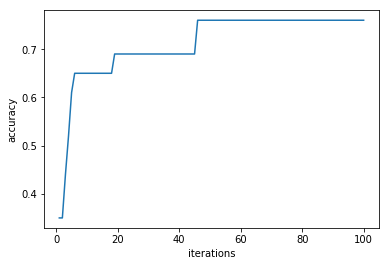

In [10]:
vweights=[]
vbiases=[]

# Initialize the entire graph
init = tf.global_variables_initializer()

# Define the updates which are to be done before each iterations
random_updates = [r.initializer for r in random_values]
updates = weightslist + biaseslist + \
    random_updates + vbiaseslist + vweightslist + \
    fit_updates + control_updates + hybrid_updates + pweightslist + pbiaseslist
req_list = losses, updates, gfit, gbiases, vweights, vbiases, gweights,accuracy_updates,nets
original_nets=nets
iter_list = []
acc_list = []
with tf.Session() as sess:
    sess.run(init)
    max_accuracy=0
    for i in range(base_config["N_ITERATIONS"]):
        # Reinitialize the Random Values at each iteration
        sess.run(hybrid_update,feed_dict={net_in: X_train, label: y_train})

        _tuple = sess.run(req_list, feed_dict={
            net_in: X_train, label: y_train})
        _losses = None
        _losses, _, gfit, gbiases, vweights, vbiases, gweights, accuracy_updates, nets = _tuple

        if (i + 1) % 1 == 0:
            iter_list.append(i+1)
            if max(accuracy_updates)>max_accuracy:
                max_accuracy=max(accuracy_updates)
            acc_list.append(max_accuracy)
        if (i + 1) % 50 == 0:
          print('Iteration:', i+1,  '\n', 'Losses:', _losses,)
          print('accuracy', max_accuracy)

    best_particle,_ = min(enumerate(_losses), key=operator.itemgetter(1))
    
    # Close the writer
    plt.plot(iter_list, acc_list)
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    plt.show()
